In [ ]:
#Import Libraries
import pandas as pd
import random
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

# Import the models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# Load and shuffle the dataset randomly
df_original = pd.read_csv("/content/DATD+Rand_training.csv")
df = shuffle(df_original)
df

,text,label
3187,penis in my butthole,OTHER
891,*uses caffeine as an antidepressant*,OTHER
2260,#panthers run defense tonight has been a beast,OTHER
1016,"@user Looks very nice, C. 🐝",OTHER
3753,i am: happy,OTHER
...,...,...
822,This is sooo depressing 🙁🙁🥺,MENTAL_HEALTH
678,@user This is so cool!! Thank you for consider...,MENTAL_HEALTH
3290,@user Thank you!,OTHER
3476,@user HAPPY BIRTHDAY PRE,OTHER


In [ ]:
# Convert labels
df['label'] = df['label'].map({'MENTAL_HEALTH': 1, 'OTHER': 0})

In [ ]:
# Clean tweets function
def clean_text(text):
    text = text.apply(lambda r: re.sub('&amp', '&', r))
    text = text.apply(lambda r: re.sub(r'\\n', ' ', r))
    text = text.apply(lambda r: re.sub(r'@[a-zA-Z0-9_]+', 'username', r))
    text = text.apply(lambda r: re.sub(r'#[a-zA-Z0-9_]+', '#', r))
    text = text.apply(lambda r: re.sub(r'https?\S+(?=\s|$)', 'url', r))
    text = text.apply(lambda r: re.sub(r'[0-9_]+', '0', r))
    text = text.replace(r'[^\x00-\x7F]+', '', regex=True)
    return text.apply(lambda x: ' '.join(re.sub(r"(#[A-Za-z0-9]+)|(/+[A-Za-z0-9]+)|(@[A-Za-z0-9]+)|(www.[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+://\S+)|(/+://\S+)", " ", x).split()))

In [ ]:
# Remove stopwords
def remove_stopwords(text):
    stop = stopwords.words('english')
    return text.apply(lambda words: ' '.join(word.lower() for word in words.split() if word not in stop))

In [ ]:
# Apply text cleaning and stopword removal
df['text'] = clean_text(df['text'])
df['text'] = remove_stopwords(df['text'])

In [ ]:
# Vectorize the text data
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df['text']).toarray()

In [ ]:
# Store labels in y variable
y = df['label']

In [ ]:
# Split the data into training and testing sets (80:20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
# Initialisation of models
models = {
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(),
    'Naive Bayes': MultinomialNB(),
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(),
    'Support Vector Machine': SVC(probability=True),
    'Gradient Boosting Machine': XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    'AdaBoost': AdaBoostClassifier()
}

In [ ]:
# Dictionary to store model evaluation parameters
metrics = {}

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [10:58:39] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


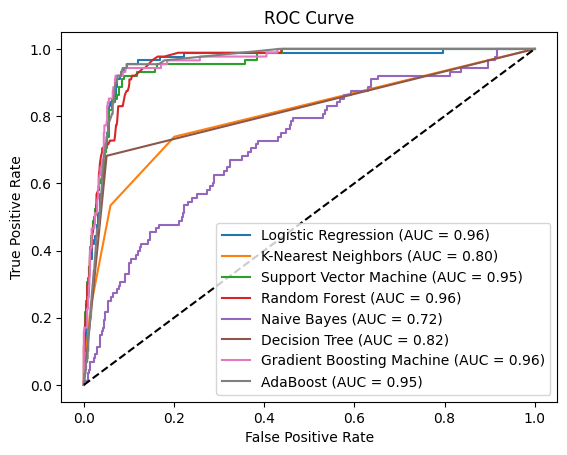

In [ ]:
# Train and evaluate each model
for model_name, model in models.items():
    model.fit(X_train, y_train.to_numpy())
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)

    # Calculate accuracy, precision, recall, F1-score, and AUC
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    precision = report['weighted avg']['precision']
    recall = report['weighted avg']['recall']
    f1 = report['weighted avg']['f1-score']
    y_proba_positive = y_proba[:, 1]
    auc = roc_auc_score(y_test, y_proba_positive)

    # Store metrics in dictionary
    metrics[model_name] = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1-score': f1,
        'auc': auc
    }

    fpr, tpr, _ = roc_curve(y_test, y_proba_positive)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc:.2f})')

# ROC Curve for all models
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.show()

In [ ]:
# Print metrics
for model_name, metric in metrics.items():
    print(f'{model_name} - Accuracy: {metric["accuracy"]:.3f}, Precision: {metric["precision"]:.3f}, Recall: {metric["recall"]:.3f}, F1-score: {metric["f1-score"]:.3f}, AUC: {metric["auc"]:.3f}')

Logistic Regression - Accuracy: 0.924, Precision: 0.922, Recall: 0.924, F1-score: 0.923, AUC: 0.955
K-Nearest Neighbors - Accuracy: 0.911, Precision: 0.893, Recall: 0.911, F1-score: 0.892, AUC: 0.804
Support Vector Machine - Accuracy: 0.930, Precision: 0.923, Recall: 0.930, F1-score: 0.924, AUC: 0.952
Random Forest - Accuracy: 0.928, Precision: 0.919, Recall: 0.928, F1-score: 0.917, AUC: 0.957
Naive Bayes - Accuracy: 0.879, Precision: 0.858, Recall: 0.879, F1-score: 0.867, AUC: 0.720
Decision Tree - Accuracy: 0.923, Precision: 0.929, Recall: 0.923, F1-score: 0.926, AUC: 0.816
Gradient Boosting Machine - Accuracy: 0.929, Precision: 0.931, Recall: 0.929, F1-score: 0.930, AUC: 0.958
AdaBoost - Accuracy: 0.927, Precision: 0.927, Recall: 0.927, F1-score: 0.927, AUC: 0.955
